<a href="https://www.kaggle.com/code/rajkamalindia04/covid19-detection-cnn-model-multiple-experiment?scriptVersionId=93144423" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Goal is to build a CNN based model without Transfer Learning which can accurately detect COVID 19.

> Performance Metrics to be optimized : Accuracy 

In this notebook, I have tried to cover some of important concept in deep learing like:
* Dropout and Batch Normalization usage
* Callback implementation
* EarlyStopping and ReduceLROnPlateau - Approach to prevent overfitting
* Impact of batch size, epoch size on Model Training.

**If you find this notebook helpful, please upvote.**

In [4]:
! rm -rf /kaggle/working/*

In [56]:
#Import libraries

import numpy as np
import pandas as pd
import pathlib

import PIL
from imageio import imread
from skimage.transform import resize

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D,Conv2D, MaxPooling2D, LSTM, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers


import os
import datetime
import time
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# 1. Data Understanding

In [6]:
data_dir_covid = pathlib.Path('../input/sarscov2-ctscan-dataset/COVID')
data_dir_non_covid = pathlib.Path('../input/sarscov2-ctscan-dataset/non-COVID')

In [7]:
img_count_covid = len(list(data_dir_covid.glob('*.png'))) 
img_count_non_covid = len(list(data_dir_non_covid.glob('*.png'))) 

print("Image count in Covid set: ",img_count_covid)
print("Image count in Non Covid set: ",img_count_non_covid)

Image count in Covid set:  1252
Image count in Non Covid set:  1229


****Both Class have almost equal number of images, so there is no class imbalance issue in Dataset.****

## 1.1. Organize Dataset into Train, Test and validation set

In [8]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [9]:
#Using Split-folders to split source folder in 3 categories i.e. Train (70%), Validation(20%) and Test(10%) set.
#Resource: https://pypi.org/project/split-folders/

import splitfolders
splitfolders.ratio("../input/sarscov2-ctscan-dataset", output="../working/dataset",
    seed=1337, ratio=(.7, .2, .1), group_prefix=None, move=False)

Copying files: 2481 files [00:05, 418.17 files/s]


In [10]:
# Define the path for train, validation and test set

data_dir_train = pathlib.Path('../working/dataset/train')
data_dir_val = pathlib.Path('../working/dataset/val')
data_dir_test = pathlib.Path('../working/dataset/test')

In [11]:
#check total image count

#as it's already known that all images are of type.png.
img_count_train = len(list(data_dir_train.glob('*/*.png'))) 
img_count_val = len(list(data_dir_val.glob('*/*.png'))) 
img_count_test = len(list(data_dir_test.glob('*/*.png'))) 

print("Image count in Train set: ",img_count_train)
print("Image count in Val set: ",img_count_val)
print("Image count in Test set: ",img_count_test)



Image count in Train set:  1736
Image count in Val set:  495
Image count in Test set:  250


# 2. Explore the Dataset

Let's check some COVID images.

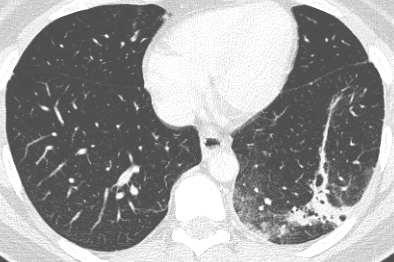

In [12]:
covid = list(data_dir_train.glob('COVID/*'))
PIL.Image.open(str(covid[0]))

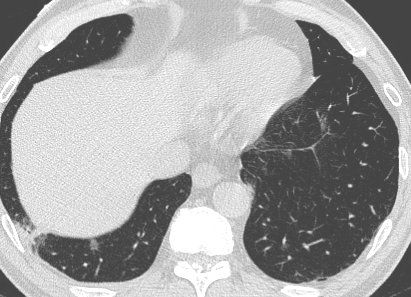

In [13]:
PIL.Image.open(str(covid[2]))

Now, Let's checkout few Non COVID images

Image size:  (363, 271)


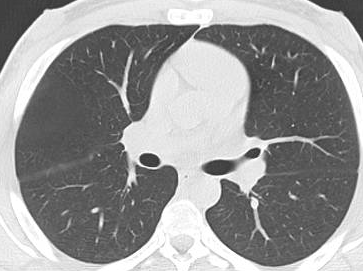

In [14]:
non_covid = list(data_dir_train.glob('non-COVID/*'))
img1 = PIL.Image.open(str(non_covid[0]))
print("Image size: " ,img1.size)
img1

Image size:  (343, 252)


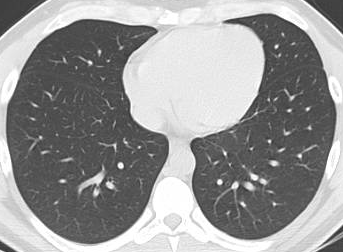

In [15]:
img2 = PIL.Image.open(str(non_covid[-1]))
print("Image size: " ,img2.size)
img2

# 3. Data Generator

Let's now use the data generator provided by Keras API.

As dataset is already splited in 3 subsets i.e. Train, Test and Validation, I will not be using validation split mechanism provided in below API.

In [16]:
def data_generator(data_source,img_height, img_width, btc_size):    
    return tf.keras.utils.image_dataset_from_directory(
        data_source,
        validation_split=None,
        subset=None,
        seed=123,
        color_mode='grayscale',
        image_size=(img_height, img_width),
        batch_size=btc_size,
        crop_to_aspect_ratio=True,
        shuffle=True
    )

***Let's define initial value of batch size, image size and num of epochs***

These are hyper parameter as well, which would help in tuning model later.

In [17]:
batch_size=32
img_height = 256
img_width = 256
num_epochs = 1

**Create dataset:**

In [18]:
train_ds = data_generator(data_dir_train,img_height, img_width, batch_size)
val_ds = data_generator(data_dir_val,img_height, img_width, batch_size)

Found 1736 files belonging to 2 classes.


2022-04-16 06:47:20.392839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Found 495 files belonging to 2 classes.


2022-04-16 06:47:20.420067: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 06:47:20.420827: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 06:47:20.422489: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-16 06:47:20.422788: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [19]:
class_names = train_ds.class_names
print(class_names)

['COVID', 'non-COVID']


In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
normalization_layer = layers.Rescaling(1./255)

# 4. Define Common Helper Functions

In [22]:
def print_param():
    print("*** Params used in Model Training ****")
    print("Batch Size: ", batch_size)
    print("Epoch Size: ", num_epochs)
    print("Image size: {} {}".format(img_height, img_width))
    print("***********************")
    

In [23]:
""" 
Below function does following things:
    - Create training and validation dataset
    - Define callback for aving model checkpoints, early stopping, ReduceLROnPlateau
    - Fit model with defined parameters i.e. batch_size, image size, num of epochs,etc.
    - Returns History object
    
Parameters:
-----------
model_init: str
            A string to be prefixed in model checkpoint name.

"""


def train_model(model_init, model):
    
    #Create training and validation sets
    train_ds = data_generator(data_dir_train,img_height, img_width, batch_size)
    val_ds = data_generator(data_dir_val,img_height, img_width, batch_size)
    
    #File name for model checkpoint
    curr_dt_time = datetime.datetime.now()
    model_name = model_init + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    
    #Stop Training, if no improvement observed. (https://keras.io/api/callbacks/early_stopping/)
    Earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=7,verbose=1)
    
    #Reduce learning rate when perf metric stopped improving. (https://keras.io/api/callbacks/reduce_lr_on_plateau/)
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001)
    
    callbacks_list = [checkpoint, LR, Earlystop]        
    
    #Print parameters used for model training.
    print_param()
    
    
    start = time.time()
    history = model.fit(train_ds, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_ds, 
                    class_weight=None, workers=1, initial_epoch=0)
    end = time.time()
    print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")
    return history

In [24]:
def plot_metrics(history):       
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# 5. Model Building

## 5.1. Base Model to start Experiment

In [25]:
num_classes = len(class_names)

In [26]:
base_model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [27]:
base_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [28]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0

In [29]:
#setting hyperparameters to experiment

batch_size=32
img_height = 256
img_width = 256
num_epochs = 50

In [30]:
history_base_model = train_model("base_model",base_model)

Found 1736 files belonging to 2 classes.
Found 495 files belonging to 2 classes.
*** Params used in Model Training ****
Batch Size:  32
Epoch Size:  50
Image size: 256 256
***********************
Epoch 1/50


2022-04-16 06:47:22.353068: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-16 06:47:23.616496: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


55/55 [==============================] - 10s 134ms/step - loss: 0.7693 - accuracy: 0.5242 - val_loss: 0.6766 - val_accuracy: 0.5051

Epoch 00001: val_loss improved from inf to 0.67662, saving model to base_model_2022-04-1606_47_21.994220/model-00001-0.76927-0.52419-0.67662-0.50505.h5
Epoch 2/50
55/55 [==============================] - 8s 134ms/step - loss: 0.6147 - accuracy: 0.6521 - val_loss: 0.5360 - val_accuracy: 0.7212

Epoch 00002: val_loss improved from 0.67662 to 0.53600, saving model to base_model_2022-04-1606_47_21.994220/model-00002-0.61466-0.65207-0.53600-0.72121.h5
Epoch 3/50
55/55 [==============================] - 7s 121ms/step - loss: 0.4750 - accuracy: 0.7725 - val_loss: 0.4355 - val_accuracy: 0.8020

Epoch 00003: val_loss improved from 0.53600 to 0.43552, saving model to base_model_2022-04-1606_47_21.994220/model-00003-0.47496-0.77247-0.43552-0.80202.h5
Epoch 4/50
55/55 [==============================] - 7s 121ms/step - loss: 0.3812 - accuracy: 0.8301 - val_loss: 0.417

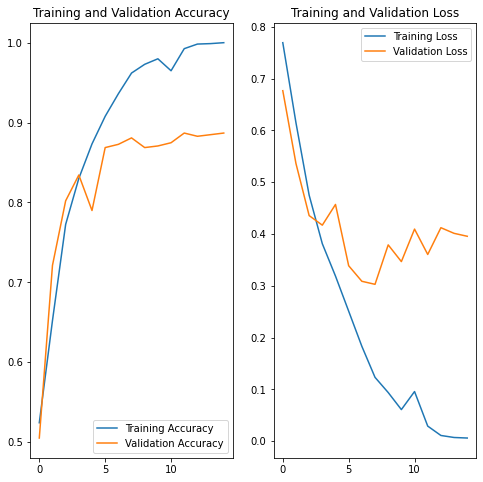

In [31]:
num_epochs = len(history_base_model.history['loss'])
plot_metrics(history_base_model)

In [32]:
min_loss_index = history_base_model.history['val_loss'].index(min(history_base_model.history['val_loss']))
print("Training Accuracy: ",history_base_model.history['accuracy'][min_loss_index])
print("Validation Accuracy: ",history_base_model.history['val_accuracy'][min_loss_index])

Training Accuracy:  0.9619815945625305
Validation Accuracy:  0.8808080554008484


**Model gives a good result with 96% Training aaccuracy and 88% validation accuracy. Let's improve this more.**

## 5.2. Let's introduce dropout and see the performance.

In [33]:
batch_size=32
img_height = 256
img_width = 256
num_epochs = 50

In [34]:
dropout_model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

dropout_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

dropout_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 16)      160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)       

In [35]:
history_dropout_model = train_model("dropout_model",dropout_model)

Found 1736 files belonging to 2 classes.
Found 495 files belonging to 2 classes.
*** Params used in Model Training ****
Batch Size:  32
Epoch Size:  50
Image size: 256 256
***********************
Epoch 1/50
55/55 [==============================] - 8s 124ms/step - loss: 0.8267 - accuracy: 0.5709 - val_loss: 0.7986 - val_accuracy: 0.5051

Epoch 00001: val_loss improved from inf to 0.79859, saving model to dropout_model_2022-04-1606_49_32.557625/model-00001-0.82672-0.57085-0.79859-0.50505.h5
Epoch 2/50
55/55 [==============================] - 8s 136ms/step - loss: 0.5579 - accuracy: 0.7010 - val_loss: 0.4758 - val_accuracy: 0.7798

Epoch 00002: val_loss improved from 0.79859 to 0.47583, saving model to dropout_model_2022-04-1606_49_32.557625/model-00002-0.55787-0.70104-0.47583-0.77980.h5
Epoch 3/50
55/55 [==============================] - 8s 123ms/step - loss: 0.4068 - accuracy: 0.8272 - val_loss: 0.3885 - val_accuracy: 0.8364

Epoch 00003: val_loss improved from 0.47583 to 0.38847, savin

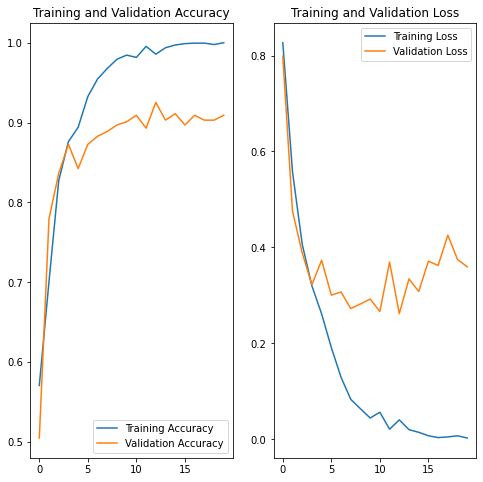

In [36]:
num_epochs = len(history_dropout_model.history['loss'])
plot_metrics(history_dropout_model)

In [37]:
min_loss_index = history_dropout_model.history['val_loss'].index(min(history_dropout_model.history['val_loss']))
print("Training Accuracy: ",history_dropout_model.history['accuracy'][min_loss_index])
print("Validation Accuracy: ",history_dropout_model.history['val_accuracy'][min_loss_index])

Training Accuracy:  0.9855991005897522
Validation Accuracy:  0.9252524971961975


**Dropout introdction seems to improve the model performance with Training accuracy 98.5% and Validation accuracy 92.5 %**

## 5.3. Batch Normalization

In [38]:
batch_size=32
img_height = 256
img_width = 256
num_epochs = 50

In [39]:
batch_norm_model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

batch_norm_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

batch_norm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 256, 256, 16)      160       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 16)      64        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 32)       

In [40]:
history_batch_norm_model = train_model("batch_norm_model",batch_norm_model)

Found 1736 files belonging to 2 classes.
Found 495 files belonging to 2 classes.
*** Params used in Model Training ****
Batch Size:  32
Epoch Size:  50
Image size: 256 256
***********************
Epoch 1/50
55/55 [==============================] - 9s 133ms/step - loss: 5.4979 - accuracy: 0.7379 - val_loss: 7.4508 - val_accuracy: 0.5051

Epoch 00001: val_loss improved from inf to 7.45075, saving model to batch_norm_model_2022-04-1606_52_34.909211/model-00001-5.49793-0.73790-7.45075-0.50505.h5
Epoch 2/50
55/55 [==============================] - 8s 130ms/step - loss: 0.3459 - accuracy: 0.8669 - val_loss: 19.1315 - val_accuracy: 0.5051

Epoch 00002: val_loss did not improve from 7.45075
Epoch 3/50
55/55 [==============================] - 9s 141ms/step - loss: 0.2067 - accuracy: 0.9188 - val_loss: 36.6259 - val_accuracy: 0.5051

Epoch 00003: val_loss did not improve from 7.45075
Epoch 4/50
55/55 [==============================] - 8s 123ms/step - loss: 0.1764 - accuracy: 0.9286 - val_loss: 3

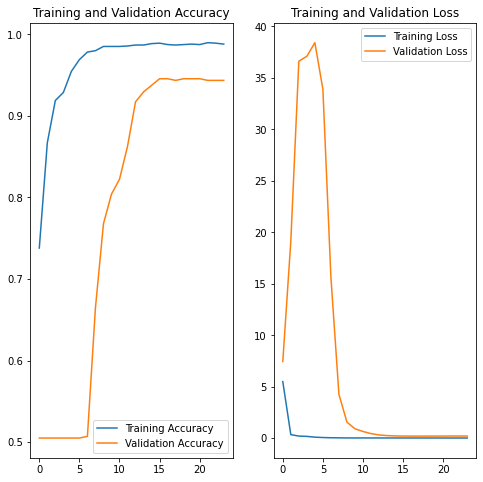

In [41]:
num_epochs = len(history_batch_norm_model.history['loss'])
plot_metrics(history_batch_norm_model)

In [42]:
min_loss_index = history_batch_norm_model.history['val_loss'].index(min(history_batch_norm_model.history['val_loss']))
print("Training Accuracy: ",history_batch_norm_model.history['accuracy'][min_loss_index])
print("Validation Accuracy: ",history_batch_norm_model.history['val_accuracy'][min_loss_index])

Training Accuracy:  0.9873272180557251
Validation Accuracy:  0.9454545378684998


***Batch Normalization + Dropout outperform than previous models with Training accuracy 98.7% and Validation accuracy 94.5%***

## 5.4. Let's experiment with a larger batch size.



In [43]:
batch_size=64
img_height = 256
img_width = 256
num_epochs = 50

In [44]:
history_large_batch_model = train_model("large_batch_model",batch_norm_model)

Found 1736 files belonging to 2 classes.
Found 495 files belonging to 2 classes.
*** Params used in Model Training ****
Batch Size:  64
Epoch Size:  50
Image size: 256 256
***********************
Epoch 1/50
28/28 [==============================] - 8s 223ms/step - loss: 0.0168 - accuracy: 0.9873 - val_loss: 0.2109 - val_accuracy: 0.9434

Epoch 00001: val_loss improved from inf to 0.21094, saving model to large_batch_model_2022-04-1606_56_18.207761/model-00001-0.01677-0.98733-0.21094-0.94343.h5
Epoch 2/50
28/28 [==============================] - 8s 219ms/step - loss: 0.0158 - accuracy: 0.9896 - val_loss: 0.2115 - val_accuracy: 0.9434

Epoch 00002: val_loss did not improve from 0.21094
Epoch 3/50
28/28 [==============================] - 9s 254ms/step - loss: 0.0167 - accuracy: 0.9891 - val_loss: 0.2115 - val_accuracy: 0.9434

Epoch 00003: val_loss did not improve from 0.21094
Epoch 4/50
28/28 [==============================] - 8s 229ms/step - loss: 0.0162 - accuracy: 0.9896 - val_loss: 0.

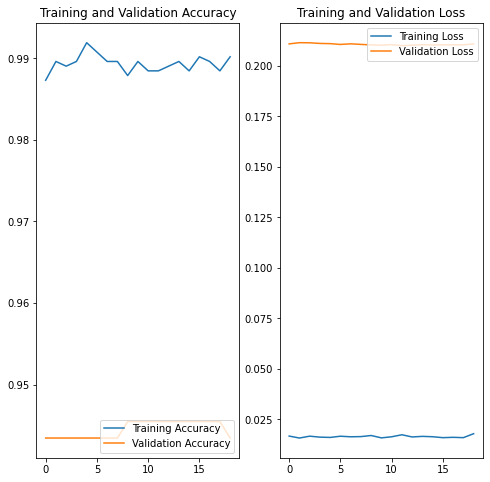

In [45]:
num_epochs = len(history_large_batch_model.history['loss'])
plot_metrics(history_large_batch_model)

In [46]:
min_loss_index = history_large_batch_model.history['val_loss'].index(min(history_large_batch_model.history['val_loss']))
print("Training Accuracy: ",history_large_batch_model.history['accuracy'][min_loss_index])
print("Validation Accuracy: ",history_large_batch_model.history['val_accuracy'][min_loss_index])

Training Accuracy:  0.9884792566299438
Validation Accuracy:  0.9454545378684998


**Larger Batch size seems to show almost same accuracy but training tooks lesser time.**

**Training accuracy 98.8% and Validation Accuracy 94.5%**

In [47]:
test_ds = data_generator(data_dir_test,img_height, img_width, batch_size)

Found 250 files belonging to 2 classes.


In [48]:
test_loss, test_acc = batch_norm_model.evaluate(test_ds, batch_size=batch_size, verbose=2)

4/4 - 1s - loss: 0.3353 - accuracy: 0.9200


**Last model is used for evaluation on test dataset and it shows accuracy of 92%, which an be considered as good.**